In [1]:
import math
import scipy
import warnings
import math as m
import numpy as np
import pandas as pd
#import scaleogram as scg

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from scipy.spatial import distance_matrix
from scipy import linalg
from scipy.optimize import minimize
from scipy.linalg import eig, eigh
from scipy.fft import fft
from scipy.special import eval_gegenbauer, sph_harm

from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA, PCA

from matplotlib import pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D



from tqdm.notebook import tqdm

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [2]:
warnings.simplefilter('ignore')

# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])


In [4]:
from scipy.special import lpmv, gamma, hyp2f1

def k_c_l_L(k,l,L):
    """ Normalizing  constant """
#     print('k,l,L', k,l,L)
#     print('L + l + k - 2', L + l + k - 2)
#     print('L - l', L - l)
    ans = ((2*L + k - 1)/ 2) \
    * math.factorial(L + l + k - 2)/math.factorial(L - l)
    ans = ans**.5
    return ans

def P_neg_mu_nu(neg_mu,nu,x):
    """The associated Legendre function"""
    mu = - neg_mu
    return (1/gamma(1+mu)) * (((1-x)/(1+x))**(mu/2)) * (hyp2f1(-nu,nu+1,1+mu,(1-x)/2))

def hat_k_P_L(k, l, L, alpha):
    hat_k_P_L_ans = k_c_l_L(k,l,L)
    hat_k_P_L_ans *= (np.sin(alpha)) ** (-(k-2)/2)
    hat_k_P_L_ans *= P_neg_mu_nu(
        -(l + ((k-2)/2)),
        +(L + ((k-2)/2)),
        np.cos(alpha)
    )
    return hat_k_P_L_ans

def high_order_sph_harm(l, theta, phi):
    k = len(l)
    high_order_sph_harm_array = np.exp(1j*l[0]*phi).reshape((-1,1))
    
    for i in range(k-1):
        high_order_sph_harm_array *= np.nan_to_num(
            hat_k_P_L(
                int(2+i),
                np.abs(l[i]),
                l[i+1],
                theta[:,i]) * (1/((2*np.pi)**.5)),
            nan = 0.0).reshape((-1,1))
        
    if l[0] > 0:
        return (-1)**l[0] * high_order_sph_harm_array
    else:
        return high_order_sph_harm_array

In [29]:
def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

def create_sp_harm(phi, theta, N = 10):
    sph_harm_discret_basis = []

    for n in range(N):
        for m in range(-n,n+1):
            if m >= 0:
                sph_harm_discret_basis.append(
                    np.real(high_order_sph_harm([m,n],theta, phi))
                )
            elif m < 0:
                sph_harm_discret_basis.append(
                    np.imag(high_order_sph_harm([m,n],theta, phi))
                )

    return np.array(sph_harm_discret_basis).T


def predict_proba_sp_harm(phi, theta, weight,N = 10):
    z = []
    i = 0
    
    for n in range(N):
        for m in range(-n,n+1):
            if m >= 0:
                z.append(weight[i] * np.real(high_order_sph_harm([m,n],theta, phi)))
                i+=1
                
            elif m < 0:
                z.append(weight[i] * np.real(high_order_sph_harm([m,n],theta, phi)))
#                 z.append(weight[i] * np.imag(
#                     sph_harm(m, n, phi, theta))
#                         )
                
                i+=1

    z = np.array(z).T
    z = z.sum(axis = 1)
    
    return 1 / (1 + np.exp(-z))

In [155]:
x_acc, t = prepare_time_series('./data/bike _accm.csv',centred =  True)
x_acc = x_acc[15780:23000]
X = HankelMatrix(x_acc, 500)

# x_acc, t = prepare_time_series('./data/long_walk_100_acc.csv',centred =  True)
# dt = 450*20
# x_acc = x_acc[7007:7007+dt]

In [156]:
pca_model = PCA(n_components = 3, )
X = HankelMatrix(x_acc[::10], 50)
X_PCA_init = pca_model.fit_transform(X)


X_sp = TrajectoryToSpherical(X_PCA_init)[:,:-1]
Y_phase = np.ones((len(X_sp),1))

In [157]:
X_PCA_init

array([[ 17.66324506, -16.42416282,   8.30926322],
       [ 20.95933978, -14.28842439,  10.15467288],
       [ 23.83886765, -11.00095749,  10.50799246],
       ...,
       [ 12.06475991,  20.27933023, -11.22390139],
       [  8.28220296,  21.89880527, -10.0582488 ],
       [  3.96460669,  22.17025277,  -7.16039606]])

In [158]:
X_PCA = X_PCA_init.copy()

In [159]:
X_PCA[:,0], X_PCA[:,1], X_PCA[:,2] = X_PCA_init[:,1], X_PCA_init[:,2], X_PCA_init[:,0]

In [160]:
fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=500, height=500)

fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                             y=X_PCA[:,1],
                             z=X_PCA[:,2],
                             mode='lines'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

In [238]:
# pca_model = PCA(n_components = 3)
# X = HankelMatrix(x_acc[:], 500)
# X_PCA = pca_model.fit_transform(X)


X_sp = TrajectoryToSpherical(X_PCA)[:,:-1]
Y_phase = np.ones((len(X_sp),1))

SAMPLE_N = 100

phi = np.linspace(0, 2*np.pi, SAMPLE_N)
theta = np.linspace(0, np.pi, SAMPLE_N)
phi, theta = np.meshgrid(phi, theta)
phi = phi.reshape(-1,1)
theta = theta.reshape(-1,1)

angle_grid = np.concatenate((theta, phi),axis = 1)
Y_phase = np.concatenate((Y_phase, np.zeros((len(angle_grid),1))),axis = 0)
angle_grid = np.concatenate((X_sp, angle_grid), axis = 0)

In [239]:
sph_harm_discret_basis = create_sp_harm(phi = angle_grid[:,1].reshape((-1,1)),
                                        theta = angle_grid[:,0].reshape((-1,1)),
                                        N = 10)

In [329]:
def fit_sp_model(sph_harm_discret_basis, Y_phase):

    clf = LogisticRegression(penalty = 'elasticnet',
                             l1_ratio = 0.5,
                             random_state=0,
                             fit_intercept = False,
                             solver='saga',
                             class_weight = 'balanced',
                             max_iter = 500
                            )
    clf.fit(sph_harm_discret_basis[0], Y_phase)

    calib = LogisticRegression(penalty = 'elasticnet',
                             l1_ratio = 0.5,
                             random_state=0,
                             fit_intercept = True,
                             solver='saga',
                             class_weight = 'balanced',
                             max_iter = 500
                            )

    calib.fit(clf.predict_proba(sph_harm_discret_basis[0])[:,1].reshape(-1,1), Y_phase)

    return clf, calib

def predict_sp_harm(sph_harm_discret_basis, clf, calib):
    proba_init = clf.predict_proba(sph_harm_discret_basis[0])[:,1].reshape(-1,1)
    return calib.predict_proba(proba_init)[:,1]

In [330]:
clf, calib = fit_sp_model(sph_harm_discret_basis, Y_phase)

In [331]:
w = list(clf.coef_[0])

In [332]:
SAMPLE_N = 200
phi = np.linspace(0, 2*np.pi, SAMPLE_N)
theta = np.linspace(0, np.pi, SAMPLE_N)
phi, theta = np.meshgrid(phi, theta)

In [333]:
def make_prediction(w, theta, phi, N, calib = calib):
    z = []
    i = 0

    for n in range(N):
        for m in range(-n,n+1):
            if m >= 0:
                z.append(
                    w[i] * np.real(
                        high_order_sph_harm([m,n],theta.reshape((-1,1)), phi.reshape((-1,1)))
                    ).reshape((-1))
                )
                i+=1

            elif m < 0:
                z.append(
                    w[i] * np.imag(
                        high_order_sph_harm([m,n],theta.reshape((-1,1)), phi.reshape((-1,1)))
                    ).reshape((-1))
                )
                i+=1

    z = np.array(z).T
    z = z.sum(axis = 1)
    z = 1 / (1 + np.exp(-z))
    z = calib.intercept_[0] + calib.coef_[0][0]*z
    z = 1 / (1 + np.exp(-z))
    return z

In [334]:
proba = make_prediction(w, theta, phi, 10).reshape((SAMPLE_N, SAMPLE_N))

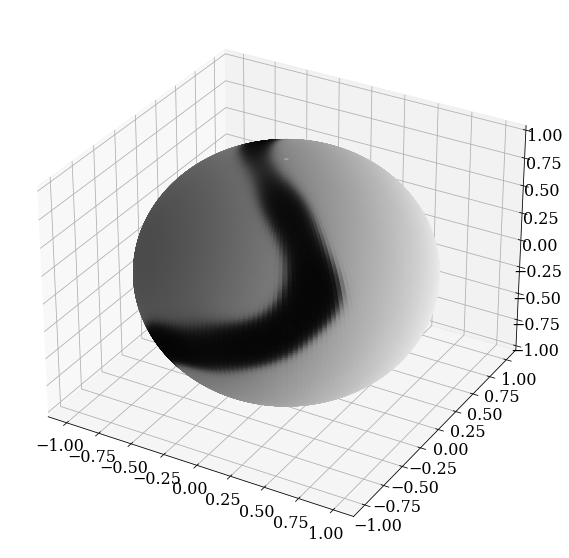

In [335]:
# The Cartesian coordinates of the unit sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, 
                rstride = 1,
                cstride = 1,
                facecolors = cm.binary(proba),
                alpha = 1
               )


plt.show()

In [401]:
s = X[0,:-1].reshape((1,-1))
D = np.std(s)
n_repeats = 200

In [402]:
s_last = s[0,-1]

In [403]:
S = np.concatenate(
    (
        np.repeat(s, repeats = n_repeats, axis = 0),
        np.linspace(s_last - D, s_last + D, n_repeats).reshape((-1,1))
    ),
    axis = 1
)

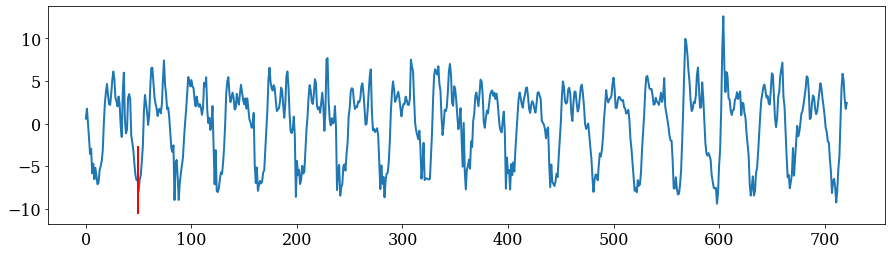

In [404]:
plt.figure(figsize=(15,4))
plt.plot(x_acc[::10])
plt.vlines(s.shape[1],s[0,-1] - D, s[0,-1] + D, 'r')

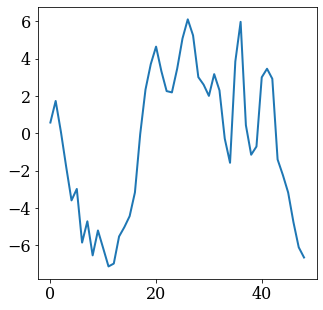

In [405]:
plt.plot(s[0])

In [406]:
S_PCA = pca_model.transform(S)

In [407]:
S_sp = TrajectoryToSpherical(S_PCA)[:,:-1]

In [408]:
s_proba = make_prediction(w, S_sp[:,1], S_sp[:,0], 5)

In [412]:
np.mean(np.linspace(s_last - D, s_last + D, n_repeats).reshape((-1,1)) * s_proba.reshape((-1,1)))

-1.4138690827196183

In [413]:
X[0,-1].reshape((1,-1))

array([[-6.4875421]])

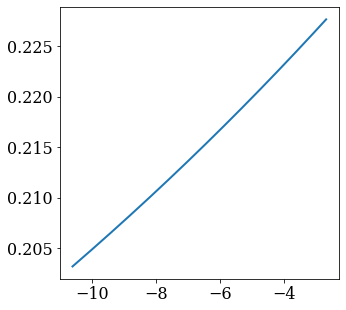

In [415]:
plt.plot(
    np.linspace(s_last - D, s_last + D, n_repeats),
    s_proba
)

In [416]:
[np.argmax(s_proba)]

[199]

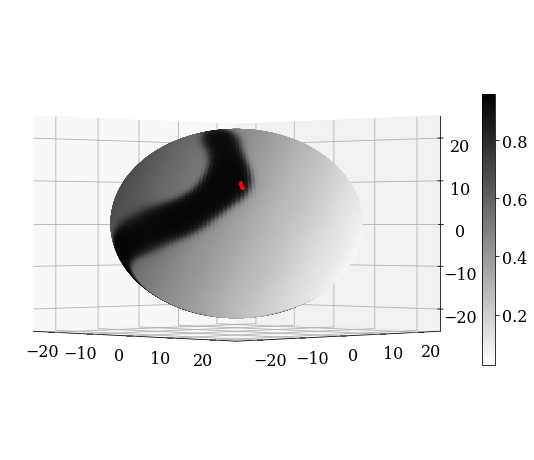

In [418]:
# The Cartesian coordinates of the unit sphere
r = 22
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, 
                rstride = 1,
                cstride = 1,
                facecolors = cm.binary(proba),
                alpha = 1
               )
ax.scatter(
    S_PCA[:,0],
    S_PCA[:,1],
    S_PCA[:,2],
    color="r",
    s = 5,
    alpha = 1
)

m = cm.ScalarMappable(cmap=cm.binary)
m.set_array(proba)

cbar = fig.colorbar(m,shrink=0.5)

ax.view_init(elev = 0, azim = -45)

plt.show()